In [184]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import copy
import math
import random
import time
import open3d as o3d
np.set_printoptions(suppress=True)
import subprocess
import ffmpeg
import argparse
import dense_crf

## Meta Params

In [109]:
NUMBER_CORNERS_TO_TRACK = 100
LK_PARAMS = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
INLIER_PERCENTAGE = 0.90 # Percentage of total images/cameras for which a feature should be inlier according to homography

## Params to be set along the code

In [110]:
REFERENCE_IMAGE = ""
FEATURES = "" # (n,1,2), n features with their coordinates in the reference image
IMAGES = ""
FEATURE_TRACKING = "" #For every feature, for every camera the coordinates of the feature => list of list of tuples
CAMERA_TRACKING = "" #for every camera, for every feature the coordinates of the feature => numpy array (M,N,2) => M camera, N features
NUMBER_CAMERAS = 0
NUMBER_FEATURES = 0
FEATURE_PIXELS = "" #Pixel values of the feature points
POINTS_IN_3D = "" #Points in 3D coordinates of the reference image frame, inverse depth initialized as suggested in paper

## Helper Functions

In [173]:
def read_extrinsics_params(file):
    data = np.genfromtxt(file, delimiter=',')
    data = np.delete(data, -1, 1)
    return data

def params_to_transfomation_mtx(params):
    transformations = []
    for i in range(len(params)):
        param = params[i]
        rodrigous_rot = param[0:3]
        translation = param[3:6]
        focal_length = param[6:7]
        distortion_coeff = param[7:9]

        rotation_matrix, _ = cv2.Rodrigues(rodrigous_rot)
        transformation_matrix = np.eye(4)
        transformation_matrix[0:3, 0:3] = rotation_matrix
        transformation_matrix[0:3, 3] = translation
        transformations.append(transformation_matrix)

    transformations = np.array(transformations)
    return transformations


def params_to_projection_mtx(params):
    projections = []
    for i in range(len(params)):
        param = params[i]
        rodrigous_rot = param[0:3]
        translation = param[3:6]
        focal_length = param[6:7]
        distortion_coeff = param[7:9]

        rotation_matrix, _ = cv2.Rodrigues(rodrigous_rot)
        transformation_matrix = np.eye(4)
        transformation_matrix[0:3, 0:3] = rotation_matrix
        transformation_matrix[0:3, 3] = translation
        K = construct_camera_matrix(camera_params)
        mat = transformation_matrix[:3, :]
        projection_matrix = K @ mat
        projections.append(projection_matrix)

    projections = np.array(projections)
    return projections

def get_transformations(file):
    params = read_extrinsics_params(file)
    transformations = params_to_transfomation_mtx(params)
    return transformations

def construct_camera_matrix(camera_params):
    K = np.array([
        [camera_params['fx'],  camera_params['s'], camera_params['cx']],
        [                  0, camera_params['fy'], camera_params['cy']],
        [                  0,                   0,                  1],
    ])
    return K

In [165]:
def point_cloud_2_depth_map(pcd):
    points_3D = np.asarray(pcd.points)
    points_3D = points_3D[ points_3D[:,2] > 0, :]
    points_3D = points_3D.T

    min_depth = np.min(points_3D[2, :])
    max_depth = np.max(points_3D[2, :])

    camera_params = dict(fx=1781.0,fy=1781.0,cx=240,cy=424,k1=0,k2=0,s=0,)
    transformations = get_transformations("../output/extrinsics.csv")

    K = construct_camera_matrix(camera_params)
    points_3D = np.vstack((points_3D, np.ones((1, points_3D.shape[1]))))

    image_coordinates = K @ (transformations[0][:3,:] @ points_3D)
    image_coordinates = np.int0(image_coordinates / image_coordinates[2, :])
    pixel_depth_val = 255 - ((points_3D[2, :] - min_depth) * 255 / (max_depth - min_depth))
    depth_image = np.zeros((camera_params['cy'] * 2, camera_params['cx'] * 2))
    height_image = int(camera_params['cy'] * 2)
    width_image = int(camera_params['cx'] * 2)

    point_in_view = 0
    for i in range(image_coordinates.shape[1]):
        if image_coordinates[1, i] < depth_image.shape[0] and image_coordinates[0, i] < depth_image.shape[1] and image_coordinates[0, i] >= 0 and image_coordinates[1, i] >= 0:
            depth_image[height_image - image_coordinates[1, i], width_image - image_coordinates[0, i]] = pixel_depth_val[i]
            point_in_view +=1

    plt.imsave("../output/sparse.png", depth_image, cmap='gray')
    return depth_image

In [112]:
def convert(feat_cam):
    cam_feat = np.zeros((len(feat_cam[0]),len(feat_cam),2))
    for i in range(len(feat_cam)):
        for j in range(len(feat_cam[i])):
            cam_feat[j][i] = np.array(feat_cam[i][j])
    return cam_feat

In [113]:
def check_rotation(path_video_file):
    meta_dict = ffmpeg.probe(path_video_file)
    rotateCode = None
    print(meta_dict['streams'][0]['tags']['rotate'])
    if int(meta_dict['streams'][0]['tags']['rotate']) == 90:
        rotateCode = cv2.ROTATE_90_CLOCKWISE
    elif int(meta_dict['streams'][0]['tags']['rotate']) == 180:
        rotateCode = cv2.ROTATE_180
    elif int(meta_dict['streams'][0]['tags']['rotate']) == 270:
        rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE
    return rotateCode

In [114]:
def getFramesFromVideo(path):
    cam = cv2.VideoCapture(path)
    frames = []
    ret,frame = cam.read()
    frame = np.flip(frame)
#     frames.append(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
    frames.append(frame)
    while(ret):
        ret,frame = cam.read()
        if frame is None:
            continue
        frame = np.flip(frame)
#         frames.append(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
        frames.append(frame)
    return frames

In [115]:
def getGrayscaleImage(image):
    grayImage = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    return grayImage

In [116]:
def displayCorners(image,corners):
    plt.imsave("../output/original_image.jpg", image) 
    corners = np.intp(corners)
    for i in corners:
        x,y = i.ravel()
        cv2.circle(image,(x,y),3,255,-1)
    plt.imshow(image),plt.show()
    plt.show()
    plt.imsave("../output/corner_detected.jpg", image)

In [117]:
def printImage(image):
    plt.imshow(image)
    plt.show()

In [118]:
def generateMatrix(points,imagePoints):
#     print(points)
    matrix = []
    for i in range(len(points)):
        temp = []
        for c in points[i]:
            temp.append(-c)
        temp.append(-1)
        for _ in range(4):
            temp.append(0)
        for c in points[i]:
            temp.append(imagePoints[i][0]*c)
        temp.append(imagePoints[i][0])
        matrix.append(copy.deepcopy(temp))
        temp = []
        for _ in range(4):
            temp.append(0)
        for c in points[i]:
            temp.append(-c)
        temp.append(-1)
        for c in points[i]:
            temp.append(imagePoints[i][1]*c)
        temp.append(imagePoints[i][1])
        matrix.append(copy.deepcopy(temp))

    matrix = np.array(matrix)
    return matrix

In [119]:
def getProjectionMatrix(matrix,projection=True):
    u,s,vh = np.linalg.svd(matrix)
    if projection:
        P = []
        P.append(list(vh[11,:4]))
        P.append(list(vh[11,4:8]))
        P.append(list(vh[11,8:]))
        P = np.array(P)
        return P
    else:
        return vh[-1][0],vh[-1][1],vh[-1][2],vh[-1][3]

In [120]:
def getKRC(P):
    H = copy.deepcopy(P[:,:3])
    h = copy.deepcopy(P[:,3])
    Hinv = np.linalg.inv(H)
    C = -np.matmul(Hinv,h)
    
    Rt,Kinv = np.linalg.qr(Hinv)
    R = Rt.T
    K = np.linalg.inv(Kinv)
    fact = K[2][2]
    K = K/fact
    rotPi = np.array([[-1,0,0],[0,-1,0],[0,0,1]])
    R = np.matmul(rotPi,R)
    K = np.matmul(K,rotPi)
    
    return K,R,C

In [121]:
def getParamsFromCameraMatrix(matrix):
    mpr = {}
    mpr['fx'] = matrix[0][0]
    mpr['fy'] = matrix[1][1]
    mpr['s'] = matrix[0][1]
    mpr['cx'] = matrix[0][2]
    mpr['cy'] = matrix[1][2]
    return mpr

In [148]:
def getCameraMatrix():
    ## Image and the correspondances for DLT
    img = cv2.imread("../data/images/camera_calibration2.jpeg")
#     print(img.shape)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.show()
    
    points = []
    points.append([0,0,0])
    points.append([0,35,0])
    points.append([65,35,0])
    points.append([65,0,0])
    points.append([65,35,-95])
    points.append([0,35,-95])
    points.append([0,0,-95])

    image1Points = []

    image1Points.append([210,435])
    image1Points.append([210,380])
    image1Points.append([265,310])
    image1Points.append([265,360])
    image1Points.append([125,270])
    image1Points.append([55,325])
    image1Points.append([65,375])
    
    P = getProjectionMatrix(generateMatrix(points,image1Points))
    cameraMat, _, _ = getKRC(P)
    return cameraMat

In [123]:
def write_point_cloud(file_name, points, colors):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd])
    o3d.io.write_point_cloud(file_name, pcd)

## Getting Data to Work On

In [124]:
images = getFramesFromVideo("../data/videos/v2.mp4")
REFERENCE_IMAGE = images[0]
IMAGES = images[1:]
print("Number of Frames",len(images))

Number of Frames 87


In [125]:
cv2.imwrite("../data/images/camera_calibration2.jpeg",cv2.cvtColor(REFERENCE_IMAGE,cv2.COLOR_BGR2RGB))

True

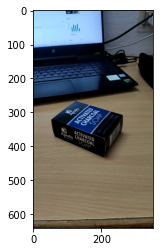

In [126]:
plt.imshow(REFERENCE_IMAGE)
plt.show()

## Step 1: Initialization

### 1.1 Taking Image 0 as Reference Image and Tracking Corners Using Shi-Tomasi Corner Detection

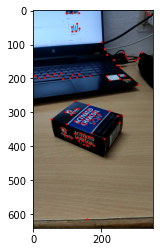

In [127]:
corners = cv2.goodFeaturesToTrack(getGrayscaleImage(np.copy(REFERENCE_IMAGE)),NUMBER_CORNERS_TO_TRACK,0.02,10)
displayCorners(np.copy(REFERENCE_IMAGE),corners)
FEATURES = np.copy(corners)

In [128]:
FEATURE_TRACKING = []
for x in FEATURES:
    FEATURE_TRACKING.append([(x[0][0],x[0][1])])

### 1.2 Tracking features from Reference Image accross all Images

In [129]:
for idx,image in enumerate(IMAGES):
    p1, st, err = cv2.calcOpticalFlowPyrLK(getGrayscaleImage(REFERENCE_IMAGE), getGrayscaleImage(image), FEATURES, None, **LK_PARAMS)
    if p1 is not None:
        p1 = p1[st==1]
        FEATURES = FEATURES[st==1]
        newTracking = []
        for i,x in enumerate(st):
            if x == 1:
                newTracking.append(FEATURE_TRACKING[i])
                newTracking[-1].append((p1[len(newTracking)-1][0],p1[len(newTracking)-1][1]))
        FEATURE_TRACKING = newTracking
        FEATURES = FEATURES.reshape((np.sum(st==1),1,2))

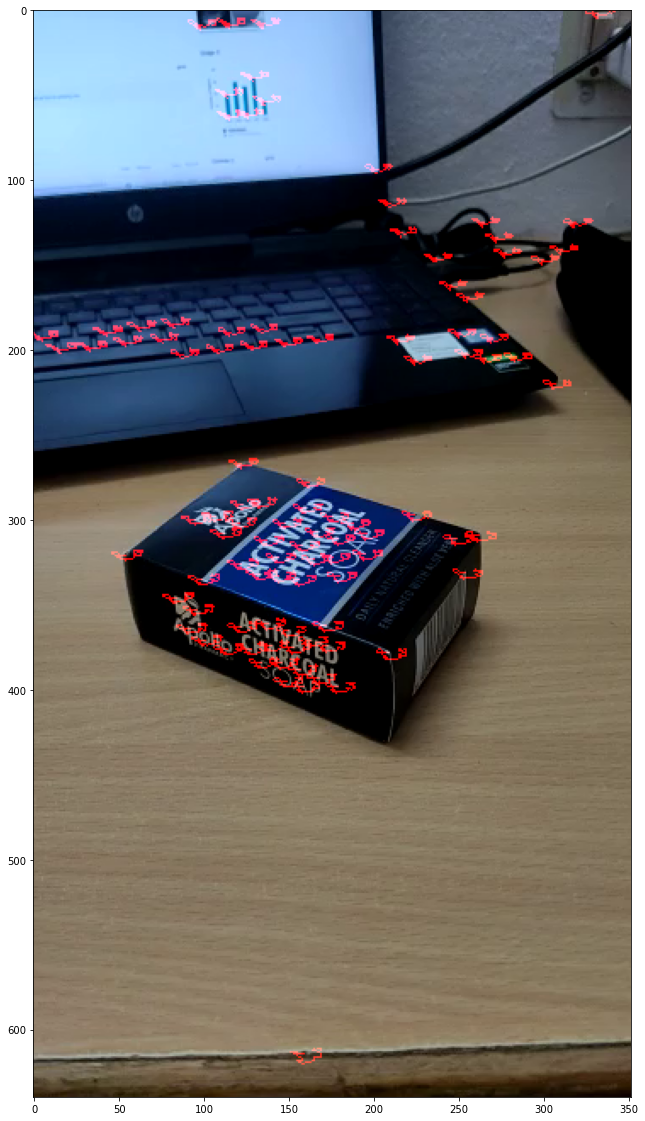

In [130]:
image = np.copy(REFERENCE_IMAGE)
mask = np.zeros_like(image)
for feature in FEATURE_TRACKING:
    feature = np.array(feature, np.int32).reshape((-1,1,2))
    cv2.polylines(mask, [feature], False, (255,0,0))
image = cv2.add(image, mask)
plt.imsave("../output/Flow.jpg", image)
plt.figure(figsize=[20,20])
plt.imshow(image)
plt.show()

### 1.3 Dealing with outliers in Feature Matching

In [131]:
CAMERA_TRACKING = convert(copy.deepcopy(FEATURE_TRACKING))

In [132]:
NUMBER_CAMERAS = CAMERA_TRACKING.shape[0]
NUMBER_FEATURES = CAMERA_TRACKING.shape[1]

In [133]:
count = np.zeros((CAMERA_TRACKING.shape[1],1))
for j in range(1,CAMERA_TRACKING.shape[0]):
    homography,inlier = cv2.findHomography(CAMERA_TRACKING[0,:,:],CAMERA_TRACKING[j,:,:],cv2.RANSAC,5.0)
    count += inlier
count[count < INLIER_PERCENTAGE*NUMBER_CAMERAS] = 0 
count[count >= INLIER_PERCENTAGE*NUMBER_CAMERAS] = 1
print("Number of features which qualify as inliers are",np.sum(count))

Number of features which qualify as inliers are 98.0


#### Displaying Outliers

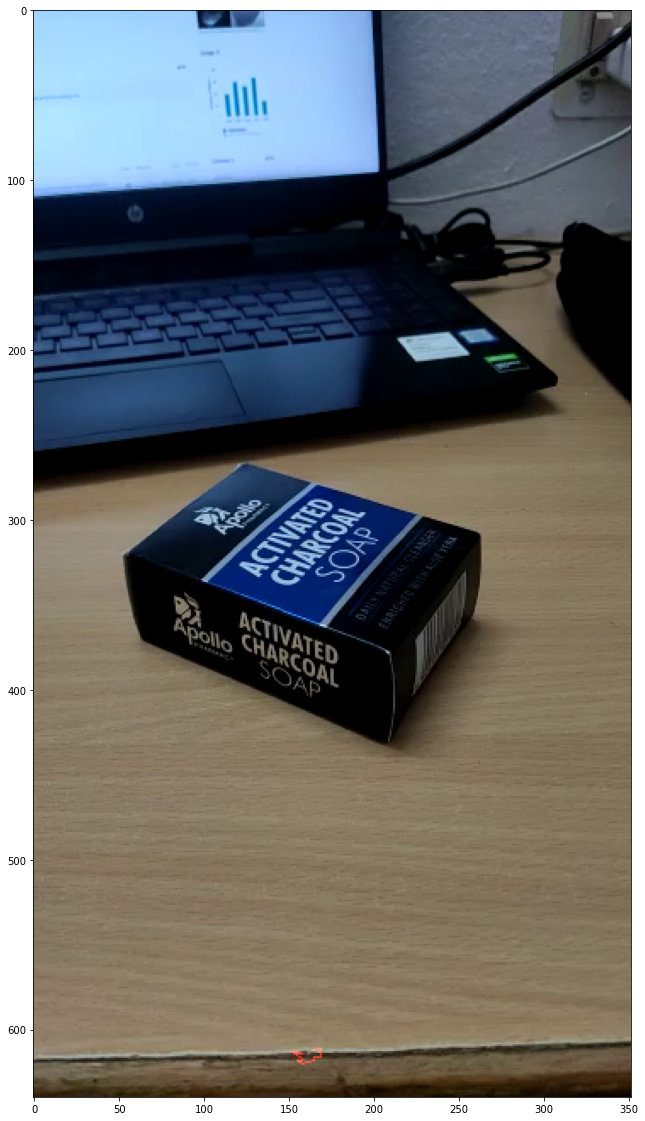

In [134]:
outlier_features = FEATURES[count==0]
outlier_features = outlier_features.reshape((np.sum(count==0),1,2))

newTracking = []
for i,x in enumerate(count):
    if x == 0:
        newTracking.append(FEATURE_TRACKING[i])

image = np.copy(REFERENCE_IMAGE)
mask = np.zeros_like(image)
for feature in newTracking:
    feature = np.array(feature, np.int32).reshape((-1,1,2))
    cv2.polylines(mask, [feature], False, (255,0,0))
image = cv2.add(image, mask)
plt.imsave("../output/Outliers_Flow.jpg", image)
plt.figure(figsize=[20,20])
plt.imshow(image)
plt.show()

#### Updating Params

In [135]:
FEATURES = FEATURES[count==1]
FEATURES = FEATURES.reshape((np.sum(count==1),1,2))
newTracking = []
for i,x in enumerate(count):
    if x == 1:
        newTracking.append(FEATURE_TRACKING[i])
FEATURE_TRACKING = newTracking
CAMERA_TRACKING = convert(copy.deepcopy(FEATURE_TRACKING))
NUMBER_CAMERAS = CAMERA_TRACKING.shape[0]
NUMBER_FEATURES = CAMERA_TRACKING.shape[1]
print("Number of Cameras",NUMBER_CAMERAS)
print("Number of Features",NUMBER_FEATURES)

Number of Cameras 87
Number of Features 98


#### Displaying Inliers

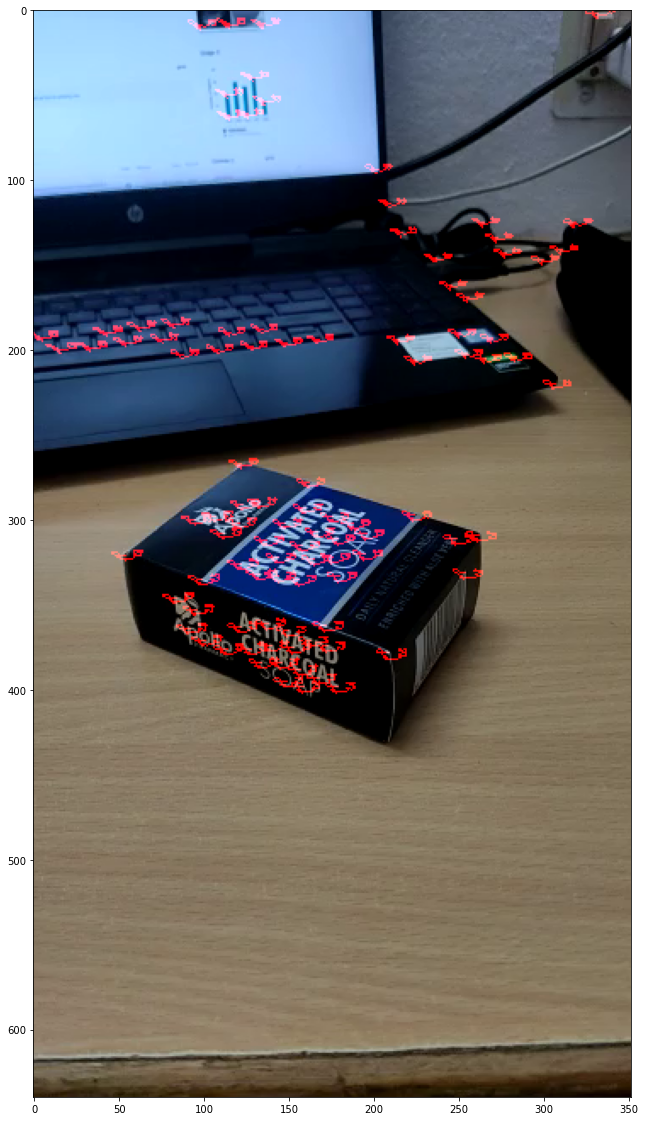

In [136]:
image = np.copy(REFERENCE_IMAGE)
mask = np.zeros_like(image)
for feature in FEATURE_TRACKING:
    feature = np.array(feature, np.int32).reshape((-1,1,2))
    cv2.polylines(mask, [feature], False, (255,0,0))
image = cv2.add(image, mask)
plt.imsave("../output/Inliers_Flow.jpg", image)
plt.figure(figsize=[20,20])
plt.imshow(image)
plt.show()

### 1.4 Initializations of 3D World Coordinates and related stuff 

In [149]:
FEATURE_PIXELS = (REFERENCE_IMAGE[FEATURES[:,0,1].astype('uint32'), FEATURES[:,0,0].astype('uint32'), :] ).astype('float64')

In [150]:
camMat = getCameraMatrix()
camParams = getParamsFromCameraMatrix(camMat)

In [151]:
print(camMat)

[[-592.40635004    3.7131052   184.25812295]
 [   0.          595.20001866  254.56000937]
 [   0.            0.            1.        ]]


In [152]:
# features = np.copy(FEATURES).reshape((NUMBER_FEATURES,2))
# ## Origin Shifting
# features[:,0] = (features[:,0] - camParams['cx'])*camParams['fy']
# features[:,1] = (features[:,1] - camParams['cy'])*camParams['fx']

# ## Depth initialised randomly, and then points inititalised as inverse depth
# DEPTH_VECTOR = np.random.uniform(2.5,4.5,(NUMBER_FEATURES))
# lastCol = (np.ones((NUMBER_FEATURES,))*camParams['fx']*camParams['fy'])/DEPTH_VECTOR
# lastCol = lastCol.reshape((NUMBER_FEATURES,1))

# ## 3D Points Created
# pts = np.concatenate((features,lastCol), axis=1)
# POINTS_IN_3D = np.copy(pts)

In [153]:
features = np.copy(FEATURES).reshape((NUMBER_FEATURES,2))
## Origin Shifting
# features[:,0] = (features[:,0] - camParams['cx'])*camParams['fy']
# features[:,1] = (features[:,1] - camParams['cy'])*camParams['fx']

## Depth initialised randomly, and then points inititalised as inverse depth
DEPTH_VECTOR = np.random.uniform(2.5,4.5,(NUMBER_FEATURES))
features[:,0] = (features[:,0])/DEPTH_VECTOR
features[:,1] = (features[:,1])/DEPTH_VECTOR

lastCol = (np.ones(NUMBER_FEATURES,))/DEPTH_VECTOR
lastCol = lastCol.reshape((NUMBER_FEATURES,1))

## 3D Points Created
pts = np.concatenate((features,lastCol), axis=1)
POINTS_IN_3D = np.copy(pts)

In [154]:
# image_pts = np.zeros((NUMBER_CAMERAS, NUMBER_FEATURES, 2))

# # creating image_pts with dimensions as camId, pointId, 2
# for i in range(NUMBER_FEATURES):
#     for j in range(NUMBER_CAMERAS):
#         image_pts[j, i, 0] = self.FEATURE_TRACKING[i][j][0]
#         image_pts[j, i, 1] = self.FEATURE_TRACKING[i][j][1]

# reference_features = image_pts[0, :, :].astype('uint16') 
# reference_features_textures = (REFERENCE_IMAGE[reference_features[:,0], reference_features[:,1], :]).astype('uint32')
# reference_features_points = np.concatenate((reference_features, np.zeros((reference_features.shape[0], 1))), axis =1)

# point_map = np.zeros((0,3))
# color_map = np.zeros((0,3))

# for i in range(0,352,5):
# #     print(i)
#     for j in range(0,640,5):
#         point_map = np.concatenate((point_map, np.array([[i, j, 0]])))
#         color_map = np.concatenate((color_map, [REFERENCE_IMAGE[i,j,:]]))

# # print(point_map.shape)
# # color_map = color_map/255
# # for i in range(len(color_map)):
# #     print(color_map[i])
# color_map = color_map.astype('uint32')
# write_point_cloud("../output/try.ply", point_map, color_map)

In [155]:
print(POINTS_IN_3D.shape)
print(REFERENCE_IMAGE.shape)
print(FEATURE_PIXELS.shape)
print(np.min(POINTS_IN_3D))
print(np.max(POINTS_IN_3D))

(98, 3)
(640, 352, 3)
(98, 3)
0.22388232387983628
144.4546356201172


In [156]:
pixels = np.zeros((98,3))
write_point_cloud("../output/initial.ply",POINTS_IN_3D,FEATURE_PIXELS/255.0),

(None,)

In [145]:
cloud = o3d.io.read_point_cloud("../output/initial.ply") # Read the point cloud
o3d.visualization.draw_geometries([cloud]) # Visualize the point cloud 

## Generating Bundle File

In [157]:
with open("../output/input_bundle.txt",'w') as fp:
#     fp.write(str(NUMBER_CAMERAS)+" "+str(NUMBER_FEATURES)+" "+str(NUMBER_CAMERAS*NUMBER_FEATURES)+"\n")
#     for i in range(NUMBER_CAMERAS):
#         fp.write(str(camParams['fx'])+" "+str(camParams['fy'])+" "+str(camParams['cx'])+" "+str(camParams['cy'])+" 0.0 0.0 1 0 0 0 1 0 0 0 1 0 0 0\n")
    
#     for i in range(NUMBER_FEATURES):
#         fp.write(str(POINTS_IN_3D[i][0])+" "+str(POINTS_IN_3D[i][1])+" "+str(POINTS_IN_3D[i][2])+"\n")

#     for i in range(NUMBER_FEATURES):
#         for j in range(NUMBER_CAMERAS):
#             fp.write(str(i)+" "+str(j)+" "+str(FEATURE_TRACKING[i][j][0])+" "+str(FEATURE_TRACKING[i][j][1])+"\n")
#     fp.close()  
    fp.write(str(NUMBER_CAMERAS)+" "+str(NUMBER_FEATURES)+"\n")
    for i in range(NUMBER_CAMERAS):
        fp.write(str(camParams['fx'])+" 0.0 0.0 1 0 0 0 1 0 0 0 1 0 0 0\n")
    
    for i in range(NUMBER_FEATURES):
        fp.write(str(POINTS_IN_3D[i][0])+" "+str(POINTS_IN_3D[i][1])+" "+str(POINTS_IN_3D[i][2])+"\n")
        for j in range(NUMBER_CAMERAS):
            fp.write(str(j)+" "+str(i*NUMBER_CAMERAS+j)+" "+str(FEATURE_TRACKING[i][j][0])+" "+str(FEATURE_TRACKING[i][j][1])+"\n")
    fp.close()  

## Running Ceres Solver

In [178]:
subprocess.call([
    "../ceres-bin/bin/bundle_adjuster",
    "--input=../output/input_bundle.txt",
    "--num_iterations=100",
    "--nonmonotonic_steps=false",
    "--initial_ply=../output/initial.ply",
    "--final_ply=../output/final.ply"
])

In [159]:
pcd = o3d.io.read_point_cloud("../output/final_point_cloud.ply")
o3d.visualization.draw_geometries([pcd]) # Visualize the point cloud 

In [177]:
depth_map = point_cloud_2_depth_map(pcd)

## Plane Sweep and CRF

In [180]:
folder = "../data/"
parser = argparse.ArgumentParser()

parser.add_argument("--folder", help='sub-directory in dataset dir', default="{}".format(folder.split('/')[-1]), required=False)
parser.add_argument("--nsamples", help='Number of depth samples', default=64, required=False)
parser.add_argument("--pc_cost", help='Path to photoconsistency cost array', default=None)
parser.add_argument("--show_unary", help='Save depth map with just unary (photoconsistency score) potentials', default=False)

parser.add_argument("--iters", help='Number of iters for CRF inference', default=100)
parser.add_argument("--p_std", help='Std. dev of positional term', default="3,3")
parser.add_argument("--c_std", help='Std. dev of color term', default="20,20,20")
parser.add_argument("--wt", help='Weight for truncated linear', default=1)
parser.add_argument("--max_p", help='Max Penalty for truncated linear', default=0.15)

parser.add_argument("--max_d", help='Max depth of computed of 3D scene', default=4)
parser.add_argument("--min_d", help='Min depth of computed of 3D scene', default=2)
parser.add_argument("--scale", help='Scale of image (downsampling)', default=2)
parser.add_argument("--patch_rad", help='Patch radius for photoconsistency', default=1)

args = parser.parse_args()

In [185]:
dense_crf.dense_depth(args)